# COVID-19 face mask detector with CNN, OpenCV

In [1]:
import cv2, os
import numpy as np
from tensorflow.python.keras.utils import np_utils   
#from keras.utils import np_utils
import imutils
import pytesseract
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
%matplotlib inline

# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

2023-08-23 21:15:21.226522: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print(np.__version__)
# original ver. : '1.18.1'
# current ver. : '1.24.3'

print(cv2.__version__)
# original ver : '4.3.0'
# current ver. : '4.8.0'

print(tf.__version__)
# original ver : '2.2.0'
# current ver. : '2.13.0'

print(keras.__version__)
# original ver : '2.4.3'
# current ver. : '2.13.1'

1.24.3
4.8.0
2.13.0
2.13.1


#### 데이터 라벨 만들기

In [5]:
data_path='../data/mask_data/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))
label_dict 

{'with_mask': 0, 'without_mask': 1}

In [6]:
label_dict = {'without_mask': 0, 'with_mask': 1}
label_dict 

{'without_mask': 0, 'with_mask': 1}

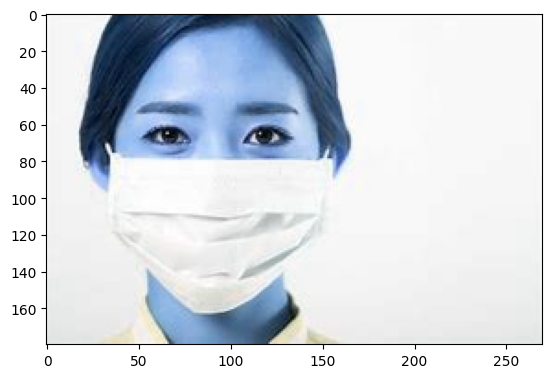

In [7]:
img = cv2.imread('../data/mask_data/with_mask/601-with-mask.jpg')
plt.imshow(img)

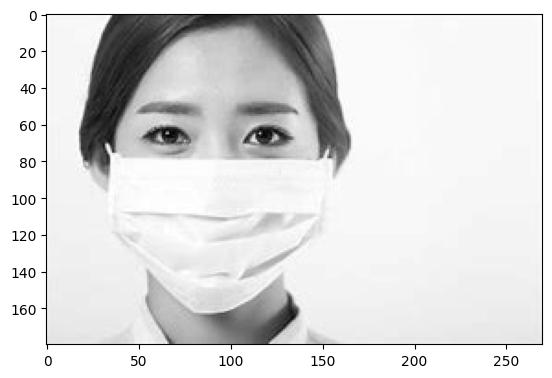

In [8]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap = 'gray')

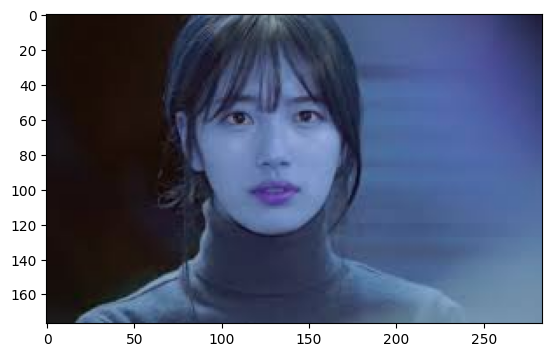

In [9]:
img = cv2.imread('../data/mask_data/without_mask/551.jpg')
plt.imshow(img)

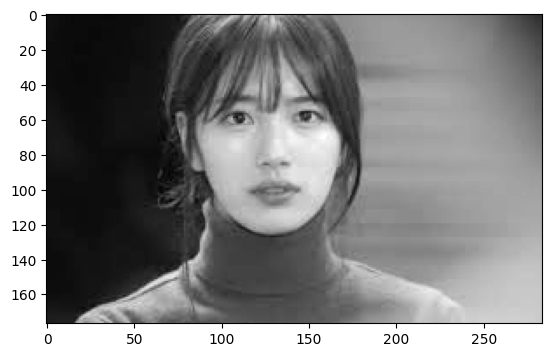

In [10]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap = 'gray')

### #데이터 불러오기

In [11]:
categories = ['without_mask', 'with_mask']
categories

['without_mask', 'with_mask']

In [12]:
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
            resized=cv2.resize(gray,(100, 100))
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            print('Exception:', e)

In [13]:
folder_path

'../data/mask_data/with_mask'

In [14]:
img_names[:5]

['419-with-mask.jpg',
 '330-with-mask.jpg',
 '277-with-mask.jpg',
 '309-with-mask.jpg',
 '570-with-mask.jpg']

In [15]:
data[:3]

[array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [226, 225, 224, ..., 220, 220, 220],
        [226, 225, 225, ..., 220, 220, 220],
        [226, 225, 224, ..., 220, 220, 220]], dtype=uint8),
 array([[ 0,  0,  0, ...,  5,  2,  3],
        [ 0,  0,  0, ...,  1,  1,  4],
        [ 0,  0,  0, ..., 58, 79, 66],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8),
 array([[255, 255, 255, ..., 210, 254, 254],
        [255, 255, 254, ..., 175, 255, 254],
        [255, 255, 254, ..., 205, 255, 254],
        ...,
        [255, 254, 254, ...,  81, 253, 254],
        [255, 254, 254, ...,  88, 254, 254],
        [255, 255, 254, ..., 141, 254, 254]], dtype=uint8)]

In [16]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0], 100, 100, 1))
target=np.array(target)

new_target=np_utils.to_categorical(target)

np.save('data', data)
np.save('target', new_target)

In [17]:
new_target

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [18]:
data=np.load('data.npy')
target=np.load('target.npy')

In [19]:
data.shape
# original&current ver. : (615, 100, 100, 1)

(615, 100, 100, 1)

In [20]:
target.shape
# original ver. : (615, 2)

(615, 2)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizer_v2 import rmsprop

### #학습용 데이터와 검증용 데이터 세트로 분할하기

In [22]:
train_data,test_data,train_target,test_target=train_test_split(data,target, test_size=0.2, random_state=42)

In [23]:
train_data.shape

(492, 100, 100, 1)

### *Data augmentation to improve generalization

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.2, 
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         shear_range=0.15, 
                         horizontal_flip=True,
                         fill_mode="nearest")

### *Hyperparameter Tuning With Bayesian Optimization

In [26]:
#input_shape = data.shape[1:]
#input_shape

(100, 100, 1)

In [65]:
def get_model(input_shape, dropout2_rate=0.5):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     name="conv2d_1"))
    model.add(Conv2D(64, (3, 3), activation='relu', name="conv2d_2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool2d_1"))
    model.add(Dropout(0.25, name="dropout_1"))
    model.add(Flatten(name="flatten"))
    model.add(Dense(128, activation='relu', name="dense_1"))
    model.add(Dropout(dropout2_rate, name="dropout_2"))
    model.add(Dense(2, activation='softmax', name="dense_2"))
    return model

In [76]:
def fit_with(input_shape, verbose, dropout2_rate, lr):

    model = get_model(input_shape, dropout2_rate)
    
    optimizer = 'rmsprop'
    # optimizer = rmsprop.RMSProp(learning_rate=lr)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    model.fit(train_data, train_target, epochs=10,
              batch_size=4, verbose=verbose)

    score = model.evaluate(test_data, test_target, steps=10, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return score[1]

In [77]:
from functools import partial

#verbose = 1
fit_with_partial = partial(fit_with, input_shape = (100, 100, 1), verbose = 1)

In [78]:
from bayes_opt import BayesianOptimization

pbounds = {'dropout2_rate': (0.1, 0.5), 'lr': (1e-4, 1e-2)}

optimizer = BayesianOptimization(
    f = fit_with_partial,
    pbounds=pbounds,
    verbose=1, 
    random_state=1
)
optimizer.maximize(init_points=10, n_iter=10)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

|   iter    |  target   | dropou... |    lr     |
-------------------------------------------------
Epoch 1/10
123/123 [==============================] - 37s 286ms/step - loss: 0.8497 - accuracy: 0.6565
Epoch 2/10
123/123 [==============================] - 36s 292ms/step - loss: 0.5763 - accuracy: 0.7480
Epoch 3/10
123/123 [==============================] - 32s 261ms/step - loss: 0.3574 - accuracy: 0.8659
Epoch 4/10
123/123 [==============================] - 31s 255ms/step - loss: 0.2427 - accuracy: 0.8943
Epoch 5/10
123/123 [==============================] - 31s 254ms/step - loss: 0.1385 - accuracy: 0.9451
Epoch 6/10
123/123 [==============================] - 31s 255ms/step - loss: 0.1116 - accuracy: 0.9675
Epoch 7/10
123/123 [==============================] - 31s 254ms/step - loss: 0.1567 - accuracy: 0.9756
Epoch 8/10
123/123 [==============================] - 31s 256ms/step - loss: 0.0933 - accuracy: 0.9715
Epoch 9/10
123/123 [==============================] - 34s 274ms/step - loss:

In [79]:
print(optimizer.max)

{'target': 0.8455284833908081, 'params': {'dropout2_rate': 0.10016896143446186, 'lr': 0.00312077776654166}}


### * Build the CNN model

In [25]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),input_shape=data.shape[1:], activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1942))
model.add(Dense(2, activation='softmax'))

In [26]:
data.shape[1:]

(100, 100, 1)

In [27]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# 최적화 모델이 저장될 폴더와 모델 이름 지정
modelpath = '../../mask_model/{epoch:03d}--{val_loss:.4f}.hdf5'
# filepath = modelpath
checkpoint = ModelCheckpoint(
    filepath = modelpath,
    # '{epoch:03d}-{val_loss:.4f}.hdf5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto')

### *Train the model

In [90]:
import scipy

In [92]:
aug.flow(train_data, train_target)

In [96]:
# Create data generator using aug.flow
train_generator = aug.flow(train_data, train_target)

In [30]:
history = model.fit(aug.flow(train_data, train_target), 
                  epochs=100, batch_size=4, callbacks=[checkpoint, early_stopping],
                  validation_data=(test_data, test_target))

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.7236 - accuracy: 0.5833

/Users/heewonkim/anaconda3/envs/mask/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 22s 1s/step - loss: 0.7236 - accuracy: 0.5833 - val_loss: 0.6613 - val_accuracy: 0.6667
Epoch 2/100
16/16 [==============================] - 19s 1s/step - loss: 0.6705 - accuracy: 0.6240 - val_loss: 0.6399 - val_accuracy: 0.6829
Epoch 3/100
16/16 [==============================] - 15s 954ms/step - loss: 0.6663 - accuracy: 0.6138 - val_loss: 0.6649 - val_accuracy: 0.6748
Epoch 4/100
16/16 [==============================] - 15s 932ms/step - loss: 0.6648 - accuracy: 0.6138 - val_loss: 0.6459 - val_accuracy: 0.6585
Epoch 5/100
16/16 [==============================] - 18s 1s/step - loss: 0.6601 - accuracy: 0.6260 - val_loss: 0.6410 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 17s 1s/step - loss: 0.6572 - accuracy: 0.6423 - val_loss: 0.6362 - val_accuracy: 0.6423
Epoch 7/100
16/16 [==============================] - 16s 1s/step - loss: 0.6562 - accuracy: 0.6159 - val_loss: 0.6198 - val_accuracy: 0.6992
Epoch 8/100
16/16 [

In [34]:
print(model.evaluate(test_data,test_target))

4/4 [==============================] - 1s 169ms/step - loss: 0.3651 - accuracy: 0.8130
[0.3650687038898468, 0.8130081295967102]


In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 flatten (Flatten)           (None, 147456)            0         
                                                                 
 dense (Dense)               (None, 128)               18874496  
                                                        

### *Evaluate the model : best model (092--0.3665.hdf5)

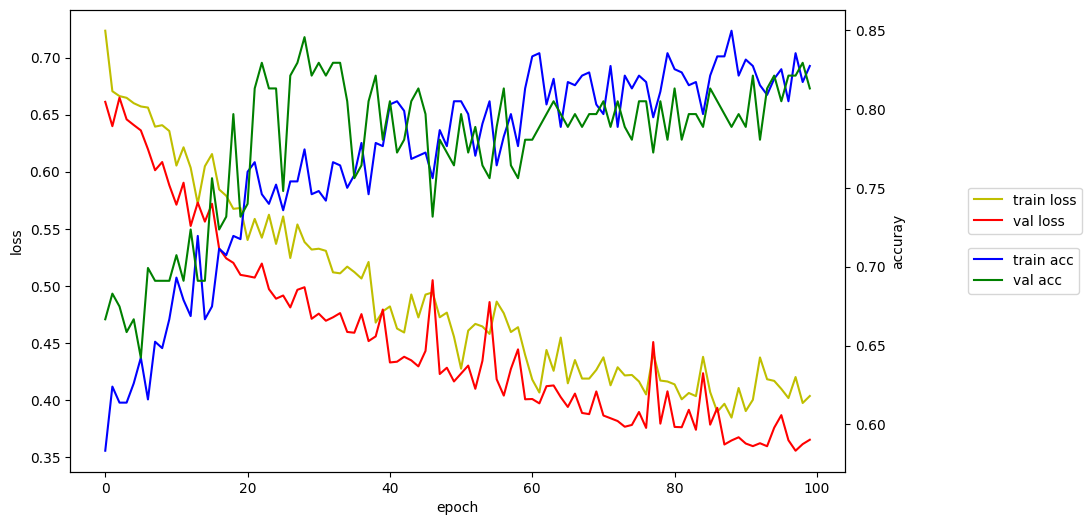

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10,6))
acc_ax = loss_ax.twinx()

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

acc_ax.legend(loc='upper left', bbox_to_anchor=(1.15, 0.5))
loss_ax.legend(loc='lower left', bbox_to_anchor=(1.15, 0.5))

plt.show()

# COVID-19 face mask detector in real-time video streams with OpenCV

In [37]:
import cv2
import numpy as np
from keras.models import load_model

labels_dict= {1 : 'with_mask', 0 : 'without_mask' }   # current categories are created as that
                                                    # but original was {1:'with_mask', 0:'without_mask'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [38]:
#video stream source : webcam or recorded video 

source = cv2.VideoCapture(0)
# cap = cv2.VideoCapture('test_mask.mp4')

In [39]:
# video output

fourcc = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
out = cv2.VideoWriter('output.avi', fourcc, 20, (640,480))

In [5]:
# warning sound in case of without_mask

import pygame, sys
from pygame import mixer

pygame.init()
pygame.mixer.init()

sound = mixer.Sound('alarm.wav')

pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


: 

In [40]:
# face recognition/classifier : haar feature
face_clsfr=cv2.CascadeClassifier(cv2.data.haarcascades + '../data/haarcascade_frontalface_default.xml')

In [42]:
# face mask detector
model = load_model('../../mask_model/092--0.3665.hdf5') #('../../mask_model/092--0.3665.hdf5')

while(True):

    ret,img = source.read()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_clsfr.detectMultiScale(gray,1.3,5)  

    for x,y,w,h in faces:
    
        face_img = gray[y:y+w,x:x+w]
        resized = cv2.resize(face_img,(100,100))
        normalized = resized/255.0
        reshaped = np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label = np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        
        if(labels_dict[label] == 'with_mask'):
            print("No Beep")
        else:
            sound.play()
            print("Beep")   
        
        cv2.putText(
          img, "{}: {:.2f}%".format(labels_dict[label], np.max(result) * 100),            
          (x, y-10),
          cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    out.write(img)
    
    if 0xFF & cv2.waitKey(5) == 27:
        break
    #if cv2.waitKey(1) & 0xFF == ord('q'):
    #    break

source.release()
out.release()

cv2.destroyAllWindows()
cv2.waitKey(1)

1/1 [==============================] - 0s 137ms/step
No Beep
1/1 [==============================] - 0s 60ms/step
No Beep
1/1 [==============================] - 0s 49ms/step
No Beep
1/1 [==============================] - 0s 62ms/step
No Beep
1/1 [==============================] - 0s 66ms/step
No Beep
1/1 [==============================] - 0s 50ms/step
No Beep
1/1 [==============================] - 0s 71ms/step
No Beep
1/1 [==============================] - 0s 42ms/step
No Beep
1/1 [==============================] - 0s 47ms/step
No Beep
1/1 [==============================] - 0s 53ms/step
No Beep
1/1 [==============================] - 0s 56ms/step
No Beep
1/1 [==============================] - 0s 44ms/step
No Beep
1/1 [==============================] - 0s 62ms/step
No Beep
1/1 [==============================] - 0s 68ms/step
No Beep
1/1 [==============================] - 0s 64ms/step
No Beep
1/1 [==============================] - 0s 68ms/step
No Beep
1/1 [==============================] - 

-1

#### Example : capturing a video

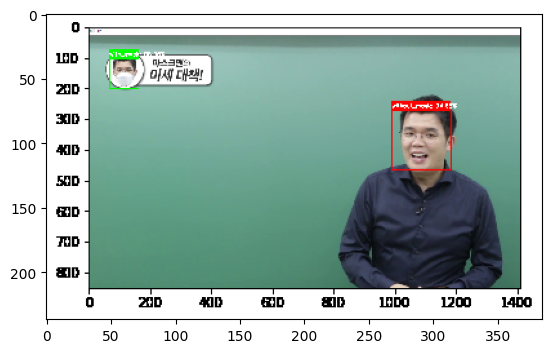

In [54]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('../data/capture_result.png')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)